# Extract the PSF  some stars in HD163466 Y3 field
=====================================================================

- Creation : Friday 2016 July 8th
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

Photometry of HD163466 with Y3


## 1) Import package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")

import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


ccdproc version 1.0.1


In [2]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture,CircularAnnulus
from photutils import aperture_photometry
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [3]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [4]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [5]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-07-08 21:13:26.335807
fits date format for the analysis :  2016-07-08T21:13:26


## 3) Configuration of the input file



In [6]:

object_name='HD163466_y3'

In [7]:
path='./HD163466_y3'
basefilename='AssScImHD163466_y3_3.fits' # check master bias
filename=os.path.join(path,basefilename)

## Read the header

In [8]:
hdulist = fits.open(filename)
prim_hdr = hdulist[0].header
exposure = prim_hdr['EXPOSURE']
date_obs = prim_hdr['DATE-OBS']

In [9]:
print date_obs
print 'exposure = ',exposure,'seconds'

2016-05-10T08:33:27.174
exposure =  5.0 seconds


## 4) Read the images

In [10]:
allimages = []
ccd_chan = ccdproc.CCDData.read(filename, hdu=0,unit='adu') 
allimages.append(ccd_chan)

data=ccd_chan.data/exposure

## 5) Shows the images

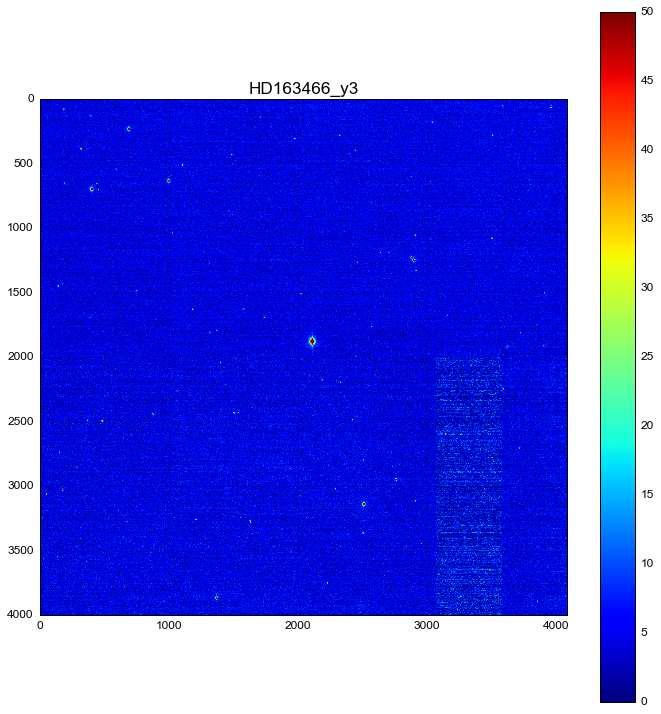

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
img=ax.imshow(ccd_chan,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)
#plt.savefig(outputfigfilename3)

# 6) Subtract background

code implemented from photutil information there:
https://photutils.readthedocs.io/en/latest/photutils/background.html#

In [12]:
from photutils.background import Background2D
bkg = Background2D(data, (100, 100), filter_size=(3, 3),method='median')

### does the background varies over the field of view ?

In [13]:
print('median background = ',bkg.background_median)
print('median rms = ',bkg.background_rms_median)

('median background = ', 0.91286347821101144)
('median rms = ', 0.48660287759741594)


### Radiography of the residual background

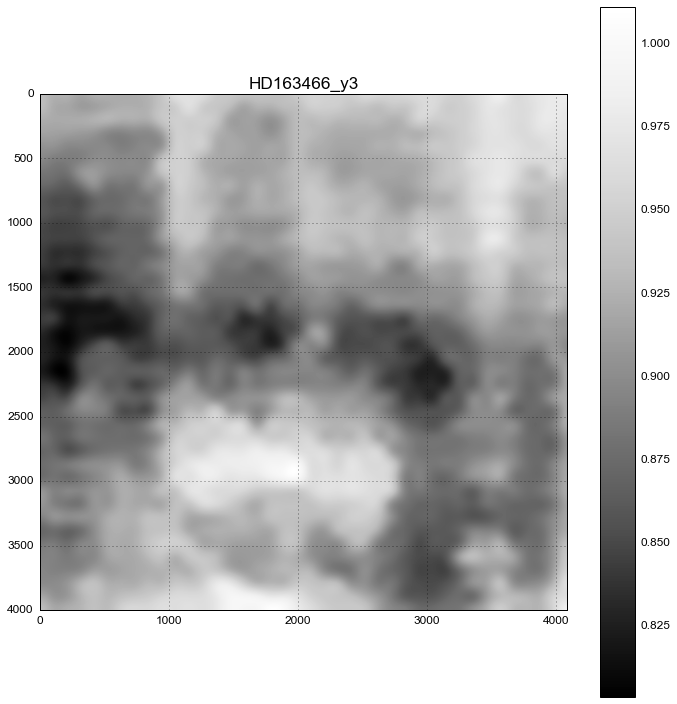

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=ax.imshow(bkg.background, cmap='Greys_r')
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

### Now subtract residual the background

In [15]:
data2=data - bkg.background

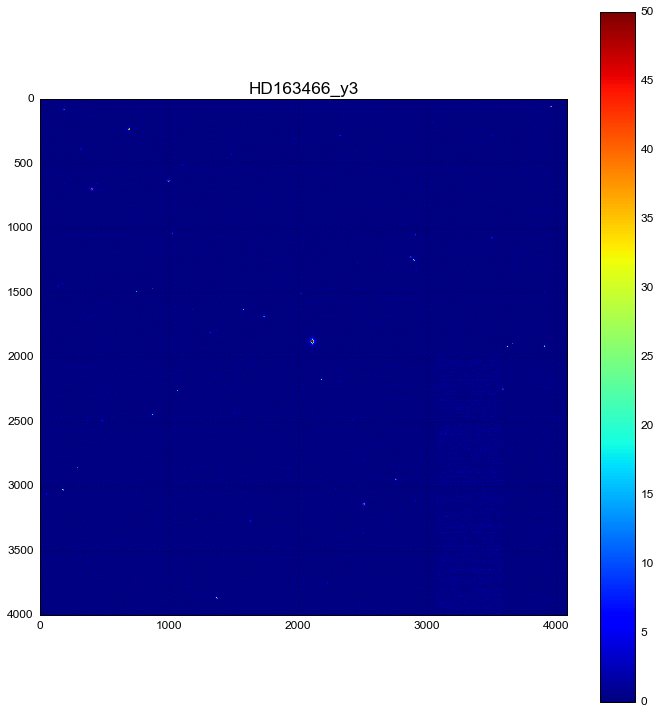

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=plt.imshow(data2, vmin=0,vmax=50.)
#img=plt.imshow(data2)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

## Crop the star

In [17]:
wpix=200

In [18]:
(y0,x0)=np.where(data2==data2.max())

In [19]:
the_star2D=data2[y0-wpix:y0+wpix,x0-wpix:x0+wpix]

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':


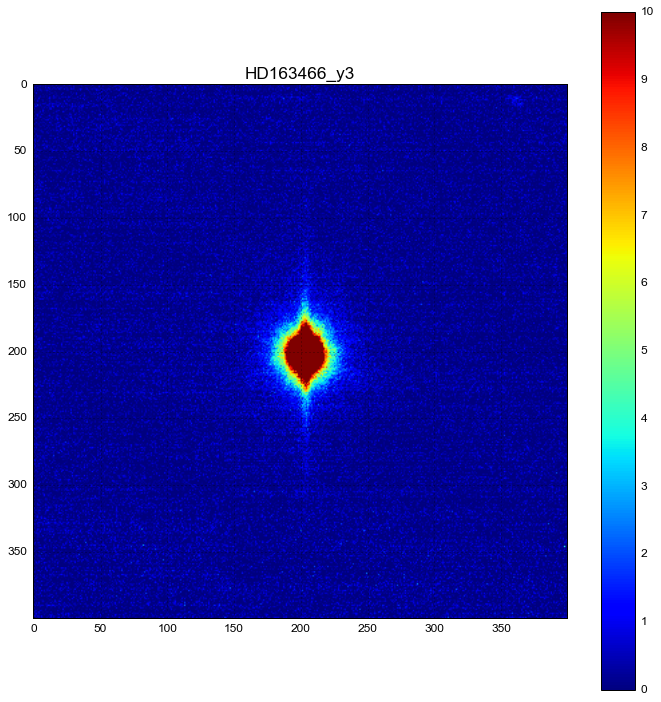

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=plt.imshow(the_star2D, vmin=0,vmax=10.)
#img=plt.imshow(data2)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

## 8.) Compute signal and noise

In [21]:
mean, median, std = sigma_clipped_stats(the_star2D, sigma=10.0, iters=5)    
print(mean, median, std)    

(0.07658571133335243, 0.031603797724463867, 0.62205867745525545)


In [22]:
sources = daofind(the_star2D - median, fwhm=3.0, threshold=50.*std)
sources.sort('flux')
print(sources)   

 id   xcentroid     ycentroid   ...      peak          flux          mag      
--- ------------- ------------- ... ------------- ------------- --------------
  2 203.908612374  201.68682332 ... 1678.91355047 16.2140837442 -3.02473102944
  3 205.015423572  204.38790645 ... 1764.50526705 24.3565628187 -3.46654000237
  1 200.202656649 200.028005546 ...  2045.9843601 33.3781192558 -3.80865465502


In [23]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,203.908612374,201.68682332,0.501377124283,-0.249056937465,0.372875596736,25.0,0.0,1678.91355047,16.2140837442,-3.02473102944
3,205.015423572,204.38790645,0.438949457489,-0.0655950859738,0.276137463551,25.0,0.0,1764.50526705,24.3565628187,-3.46654000237
1,200.202656649,200.028005546,0.46794129495,0.181630124006,-0.116254575186,25.0,0.0,2045.9843601,33.3781192558,-3.80865465502


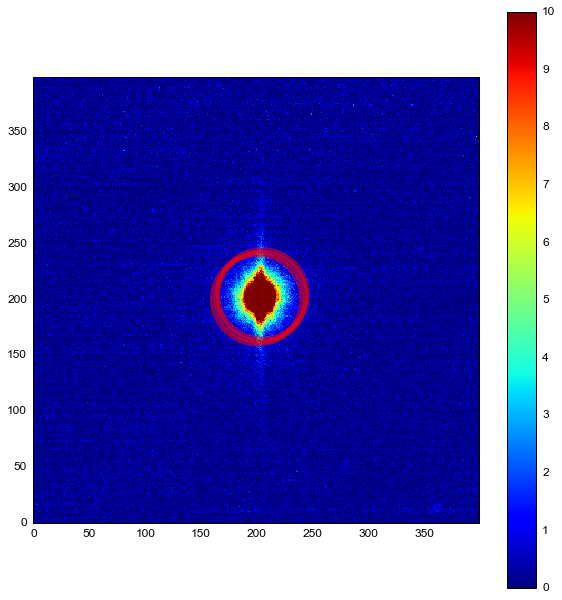

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=40.)
norm = ImageNormalize(stretch=SqrtStretch())
im=ax.imshow(the_star2D,vmin=0,vmax=10.,origin='lower',interpolation='None')
#ax.imshow(data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='red', lw=5., alpha=0.5)
plt.colorbar(im)

## The PSF

In [25]:
thePSF_2D=the_star2D

In [26]:
thepsfX=the_star2D.sum(axis=0)
thepsfY=the_star2D.sum(axis=1)

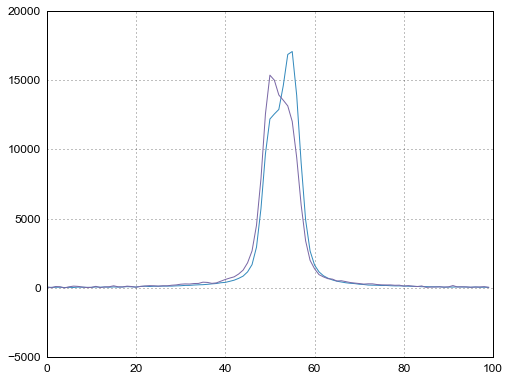

In [27]:
plt.plot(thepsfX[150:250])
plt.plot(thepsfY[150:250])

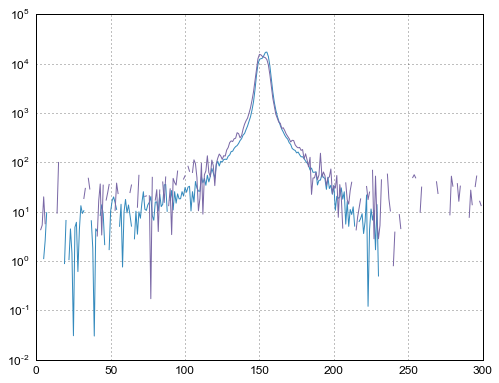

In [28]:
plt.semilogy(thepsfX[50:350])
plt.semilogy(thepsfY[50:350])

In [29]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    weights=np.where(weights>0,weights,0)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

In [30]:
np.average(np.arange(thepsfX.shape[0]),weights=thepsfX)

202.23860850768511

In [31]:
(mx,sigx)=weighted_avg_and_std(np.arange(thepsfX.shape[0]),thepsfX)

In [32]:
(my,sigy)=weighted_avg_and_std(np.arange(thepsfY.shape[0]),thepsfY)

In [33]:
print 'sigx = ',sigx

sigx =  11.8502581836


In [34]:
print 'sigy = ',sigy

sigy =  23.5563747919


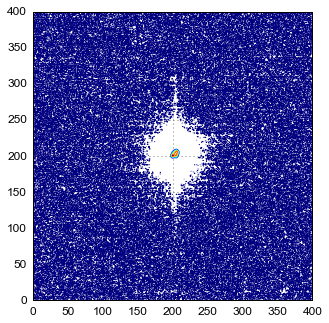

In [35]:
plt.figure(figsize=(5,5))
#onepsf2 = onepsf / np.linalg.norm(onepsf, axis=-1)[:, np.newaxis]
onepsf2 = thePSF_2D / np.sum(thePSF_2D)
levels=np.array([1,10.,100.,1000.,10000.,100000.])
#plt.contour(onepsf2,levels=levels) 
plt.contour(onepsf2,origin='lower')

# Photometry

In [36]:
apertures = CircularAperture([my,mx], r=3*max([sigx,sigy]))

In [37]:
phot_table = aperture_photometry(the_star2D, apertures)

In [38]:
print(phot_table)

 aperture_sum  xcenter [1]   ycenter [1] 
                                         
------------- ------------- -------------
154181.493858 201.809085632 202.704347949


In [39]:
sigmapix=max([sigx,sigy])
position=[my,mx]

In [40]:
#aperture_names=['ap_1sig','ap_2sig','ap_3sig','ap_4sig','ap_5sig','ap_10sig']
radii = np.array([sigmapix,2*sigmapix,3*sigmapix,4*sigmapix,5*sigmapix,10*sigmapix])
flux = []

In [41]:
for radius in radii:
    flux.append(aperture_photometry(the_star2D, CircularAperture(positions, radius)))

In [42]:
from astropy.table import hstack

In [43]:
phot_table = hstack(flux)

In [44]:
print(phot_table['aperture_sum_1', 'aperture_sum_2', 'aperture_sum_3','aperture_sum_4', 'aperture_sum_5', 'aperture_sum_6'])   

aperture_sum_1 aperture_sum_2 aperture_sum_3 ... aperture_sum_5 aperture_sum_6
                                             ...                              
-------------- -------------- -------------- ... -------------- --------------
 145423.870728  152060.822754  154159.778976 ...  155271.266024  154628.843206
 145297.517847  152042.619824  154131.675448 ...  155269.041515  154618.009963
 145240.994125  152024.696954  154193.002975 ...   155284.23746   154624.82063


## Final choice

In [45]:
star_aperture=CircularAperture(position, 3*sigmapix)

In [46]:
rawflux_table = aperture_photometry(the_star2D, star_aperture)

In [47]:
annulus_apertures = CircularAnnulus(position, r_in=5*sigmapix, r_out=7*sigmapix)

In [48]:
bkgflux_table = aperture_photometry(the_star2D, annulus_apertures)

In [49]:
phot_table = hstack([rawflux_table, bkgflux_table], table_names=['raw', 'bkg'])

In [50]:
bkg_mean = phot_table['aperture_sum_bkg'] / annulus_apertures.area()

## Result on photometry

In [51]:
bkg_sum = bkg_mean * apertures.area()
final_sum = phot_table['aperture_sum_raw'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
print(phot_table['residual_aperture_sum']) 

residual_aperture_sum
                     
---------------------
        154384.629176


### Background fluctuation

In [52]:
med=np.median(the_star2D)   # average background level

In [53]:
data_error_scale=np.sqrt(np.median((the_star2D-med)**2))  # RMS